# Regression with Different Output Format under Various Data Conditions

In this experience, we test the following output format for regression task under several different data coditions.
- Numerical output
- Regression as classification (grid-out)

The data coditions include:
- Sparse (few data)
- Grouped
  - Biased (parallel data)
  - Completely different mode, uncorrelated data (cross)
  - Partially diversed (split)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "regression_test_2"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
def draw_func(func_in, x_min=-5, x_max=5, mark='r--', linewidth=1, label='func'):
    n_sample = 100
    X_func = np.linspace(x_min, x_max, n_sample).reshape(n_sample, 1)
    y_func = func_in(X_func)
    plt.plot(X_func, y_func, mark, linewidth=linewidth, label=label)

Generate polynomial data

In [4]:
poly_a1 = 5.0
# poly_a1 = -10.0 # 5.0
#
sin_a = 0.0
# sin_a = 10.0
sin_f = 0.1 # 0.2
#
def func_0(X): # Reference
    return 0.5 * X**3 + 0.5 * X**2 + (poly_a1)*X + 2 + sin_a*np.sin(2.0*np.pi*sin_f*X)
def func_1(X): # Variation 1: parellel
    return 0.5 * X**3 + 0.5 * X**2 + (poly_a1)*X + 30 + sin_a*np.sin(2.0*np.pi*sin_f*X)
def func_2(X): # Variation 2: cross
    return -0.5 * X**3 + 0.5 * X**2 + (poly_a1)*X + 30 + sin_a*np.sin(2.0*np.pi*sin_f*X)
def func_3(X): # Variation 3: slightly split
    return 0.3 * X**3 + 1.0 * X**2 + (poly_a1)*X + 15 + sin_a*np.sin(2.0*np.pi*sin_f*X)
def func_4(X): # Sine wave~
    return 0.5 * X**3 + 0.5 * X**2 + (poly_a1)*X + 2 + 20.0*np.sin(2.0*np.pi*sin_f*X) # 50.0

In [5]:
func_dict = dict()
#-----------------#
func_dict["f1"] = func_0
#-----------------#
# func_dict["f2"] = func_1
# func_dict["f2"] = func_2
func_dict["f2"] = func_3
# func_dict["f2"] = func_4
#-----------------#
func_dict["f3"] = func_4
#-----------------#

# Note: func_dict["f_avg"] depends on multiout_type and is calculated in each section of multiout_type

In [6]:
np.random.seed(42)
m = 100 # 50 # 100 # 200
m_train = m // 5 * 4
print("(m, m_train) = (%d, %d)" % (m, m_train))

# Input
is_gapped = True
# is_gapped = False
#
if not is_gapped:
    X_data = 10 * np.random.rand(m, 1) - 5 # Note: X is randomly sampled, so we don't need to shuffle the data again
else:
    X_data = np.concatenate( (np.linspace(-5.0, -2.0, m//2), np.linspace(2.0, 5.0, m-m//2)) )
    X_data = X_data.reshape((m,1))
    np.random.shuffle(X_data)

# Output, multiout_type in {1, 2, 3}
# multiout_type = 1      
multiout_type = 2 
# multiout_type = 3 
if multiout_type == 2:
    m_h = m // 2
    X_data_1 = X_data[:m_h]
    X_data_2 = X_data[m_h:]
    y_data_pure_1 = func_dict["f1"](X_data_1) 
    y_data_pure_2 = func_dict["f2"](X_data_2) 
    y_data_pure = np.vstack([y_data_pure_1, y_data_pure_2])
    print("y_data_pure.shape = %s" % str(y_data_pure.shape))
    # Average line
    func_dict["f_avg"] = ( lambda X: 0.5*func_dict["f1"](X) + 0.5*func_dict["f2"](X) )
    #
elif multiout_type == 3: # with "avg" line
    m_t = m // 3
    X_data_1 = X_data[:m_t]
    X_data_2 = X_data[m_t:(2*m_t)]
    X_data_3 = X_data[(2*m_t):]
    y_data_pure_1 = func_dict["f1"](X_data_1) 
    y_data_pure_2 = func_dict["f2"](X_data_2) 
    y_data_pure_3 = func_dict["f3"](X_data_3) 
    y_data_pure = np.vstack([y_data_pure_1, y_data_pure_2, y_data_pure_3])
    print("y_data_pure.shape = %s" % str(y_data_pure.shape))
    # Average line
    func_dict["f_avg"] = ( lambda X: (func_dict["f1"](X) + func_dict["f2"](X) + func_dict["f3"](X))/3.0 )
    #
else: # multiout_type == 1
    # Average line
    func_dict["f_avg"] = ( lambda X: 0.5*func_dict["f1"](X) + 0.5*func_dict["f2"](X) )
    y_data_pure = func_dict["f_avg"](X_data)

    
# Label (+noise)
n_stddev = 2.0
# n_stddev = 10.0
y_data = y_data_pure + np.random.randn(m, 1) * n_stddev
print("y_data.shape = %s" % str(y_data.shape))

(m, m_train) = (100, 80)
y_data_pure.shape = (100, 1)
y_data.shape = (100, 1)


In [7]:
# Method 1: simply slice
# X_train = X_data[:m_train]
# y_train = y_data[:m_train]
# X_valid = X_data[m_train:]
# y_valid = y_data[m_train:]

# Method 2: shuffle
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [8]:
print(X_train.shape)

(80, 1)


In [9]:
def draw_normal_func(func_dict):
    if multiout_type != 1:
        draw_func(func_dict["f1"], mark='c:', label="f1")
        draw_func(func_dict["f2"], mark='g:', label="f2")
    if multiout_type == 3:
        draw_func(func_dict["f3"], mark='y:', label="f3")
    draw_func(func_dict["f_avg"], mark='m--', label="f_avg")

Saving figure training_data


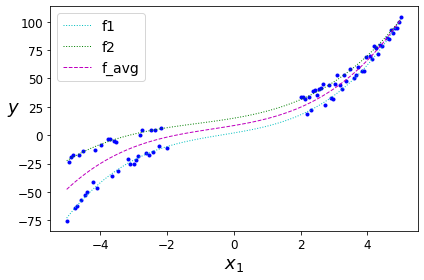

In [10]:
plt.plot(X_train, y_train, "b.")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
save_fig("training_data")
plt.show()

In [11]:
prediction_error_dict = dict()

def get_prediction_error(func_in, func_dict, name="", x_min=-5, x_max=5, prediction_error_dict=prediction_error_dict):
    n_sample = 100
    X_func = np.linspace(x_min, x_max, n_sample).reshape(n_sample, 1)
    y_func = func_in(X_func).reshape((n_sample,1))
    y_gt = func_dict["f_avg"](X_func).reshape((n_sample,1))
    print("y_func.shape = %s" % str(y_func.shape))
    print("y_gt.shape = %s" % str(y_gt.shape))
#     total_error = np.sqrt(np.square(y_func - y_gt).mean())
    total_error = np.abs(y_func - y_gt).mean()
    prediction_error_dict[name] = total_error
    return total_error

def print_all_prediction_error(is_logging_to_screen=True, prediction_error_dict=prediction_error_dict):
    _s = ""
    for _n in prediction_error_dict:
        _s += ("%s: %f" % (_n, prediction_error_dict[_n])) + "\n"
    if is_logging_to_screen:
        print(_s)
    return _s
        
def save_prediction_errors(is_logging_to_screen=False, prediction_error_dict=prediction_error_dict):
    path = os.path.join(IMAGES_PATH, "prediction_errors.txt")
    print("Saving all prediction errors to [%s]." % path)
    _s = print_all_prediction_error(is_logging_to_screen=is_logging_to_screen, prediction_error_dict=prediction_error_dict)
    with open(path, "w") as _f:
        _f.write(_s)
    return True

# Simple FCs (number --> number)

Build the regression model

In [12]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=0.0001, momentum=0.9)
model.compile(loss="mean_squared_error", optimizer=optimizer)
# optimizer = keras.optimizers.Adam(lr=0.01)
# model.compile(loss="mean_absolute_error", optimizer=optimizer)

C:\Users\benso\anaconda3\envs\ml\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [13]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid))

Epoch 1/100
3/3 [==============================] - 1s 99ms/step - loss: 2507.3081 - val_loss: 1708.8529
Epoch 2/100
3/3 [==============================] - 0s 19ms/step - loss: 2449.6917 - val_loss: 1647.8398
Epoch 3/100
3/3 [==============================] - 0s 26ms/step - loss: 2352.0815 - val_loss: 1551.1898
Epoch 4/100
3/3 [==============================] - 0s 34ms/step - loss: 2178.7847 - val_loss: 1354.1702
Epoch 5/100
3/3 [==============================] - 0s 36ms/step - loss: 1787.4446 - val_loss: 901.3063
Epoch 6/100
3/3 [==============================] - 0s 28ms/step - loss: 906.0529 - val_loss: 363.5572
Epoch 7/100
3/3 [==============================] - 0s 34ms/step - loss: 490.0430 - val_loss: 659.8012
Epoch 8/100
3/3 [==============================] - 0s 29ms/step - loss: 613.5101 - val_loss: 181.8701
Epoch 9/100
3/3 [==============================] - 0s 24ms/step - loss: 342.3111 - val_loss: 330.8617
Epoch 10/100
3/3 [==============================] - 0s 26ms/step - loss: 

3/3 [==============================] - 0s 16ms/step - loss: 159.0457 - val_loss: 137.9922
Epoch 81/100
3/3 [==============================] - 0s 17ms/step - loss: 163.1567 - val_loss: 136.7507
Epoch 82/100
3/3 [==============================] - 0s 20ms/step - loss: 166.7840 - val_loss: 137.2765
Epoch 83/100
3/3 [==============================] - 0s 17ms/step - loss: 164.1604 - val_loss: 143.4881
Epoch 84/100
3/3 [==============================] - 0s 20ms/step - loss: 159.7080 - val_loss: 146.3888
Epoch 85/100
3/3 [==============================] - 0s 21ms/step - loss: 159.3070 - val_loss: 152.4737
Epoch 86/100
3/3 [==============================] - 0s 16ms/step - loss: 160.3112 - val_loss: 152.2865
Epoch 87/100
3/3 [==============================] - 0s 21ms/step - loss: 158.3098 - val_loss: 141.3040
Epoch 88/100
3/3 [==============================] - 0s 14ms/step - loss: 159.0811 - val_loss: 132.4577
Epoch 89/100
3/3 [==============================] - 0s 20ms/step - loss: 159.8349 - va

Plot the result

Saving figure num_num_training_curve


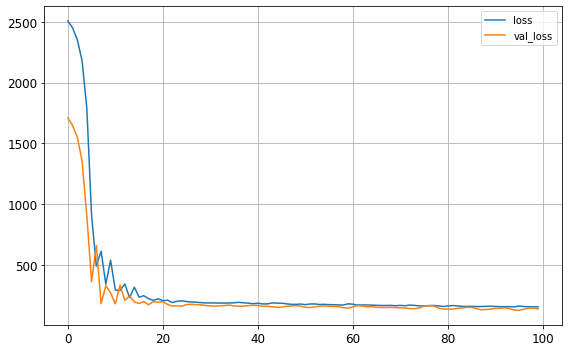

In [14]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
save_fig("num_num_training_curve")
plt.show()

Saving figure num_num_prediction


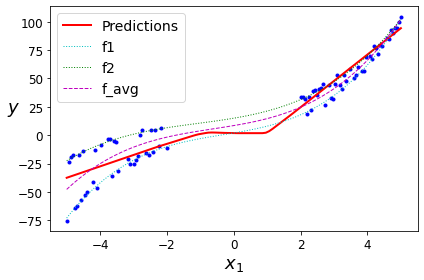

In [15]:
# X_new = np.linspace(-5, 5, 100).reshape(100, 1)
# y_new = model.predict(X_new)
#
plt.plot(X_train, y_train, "b.")
# plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
draw_func(model.predict, mark='r-', linewidth=2, label="Predictions")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
save_fig("num_num_prediction")
plt.show()

In [16]:
get_prediction_error(model.predict, func_dict, name="num-num")

y_func.shape = (100, 1)
y_gt.shape = (100, 1)


5.393838472294629

# Simulated CNN Feature Map (1-D grids, grid --> number)

In [17]:
class num2grid(keras.layers.Layer):
    def __init__(self, units, x_min=-10, x_max=10, sigma=1.0, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.x_min = x_min
        self.x_max = x_max
        self.sigma = sigma
        self.sigma2 = self.sigma**2
        self.activation = keras.activations.get(activation)
        
    def build(self, batch_input_shape):
        #
        self.x_grid = np.linspace(self.x_min, self.x_max, self.units, endpoint=True)
#         print("self.x_grid.shape = %s" % str(self.x_grid.shape))
        #
        super().build(batch_input_shape) # must be at the end
        
    def call(self, X):
        '''
        Input shape:  (batch, X_chanel)
        Output shape: (batch, grid_unit) 
        
        self.x_grid shape: (grid_unit,)
        '''
        gauss_grid = tf.exp( -(self.x_grid - X)**2 / (2.0*self.sigma2) )
        print("X.shape = %s" % str(X.shape))
        print("gauss_grid.shape = %s" % str(gauss_grid.shape))
        return self.activation(gauss_grid)
    
    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 
                "units": self.units,
                "x_min": self.x_min,
                "x_max": self.x_max,
                "sigma": self.sigma,
                "activation": keras.activations.serialize(self.activation)}

In [18]:
model = keras.models.Sequential([
    num2grid(5,x_min=-10, x_max=10, sigma=3.0, input_shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
#     keras.layers.Dense(100, activation="relu", kernel_regularizer=tf.keras.regularizers.l1(0.01)),
#     keras.layers.Dense(30, activation=keras.layers.LeakyReLU(alpha=0.2) ),
#     keras.layers.Dense(30, activation="selu"),
#     keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

# optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)
# model.compile(loss="mean_squared_error", optimizer=optimizer)
optimizer = keras.optimizers.Adam(lr=0.1)
model.compile(loss="mean_absolute_error", optimizer=optimizer)

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


C:\Users\benso\anaconda3\envs\ml\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [19]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid))

Epoch 1/100
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
1/3 [=========>....................] - ETA: 0s - loss: 40.9966X.shape = (None, 1)
gauss_grid.shape = (None, 5)
3/3 [==============================] - 1s 79ms/step - loss: 41.4462 - val_loss: 32.9112
Epoch 2/100
3/3 [==============================] - 0s 18ms/step - loss: 38.8744 - val_loss: 30.3133
Epoch 3/100
3/3 [==============================] - 0s 33ms/step - loss: 34.2480 - val_loss: 26.0946
Epoch 4/100
3/3 [==============================] - 0s 39ms/step - loss: 27.7423 - val_loss: 20.5894
Epoch 5/100
3/3 [==============================] - 0s 20ms/step - loss: 20.6281 - val_loss: 15.0811
Epoch 6/100
3/3 [==============================] - 0s 47ms/step - loss: 17.1209 - val_loss: 12.8631
Epoch 7/100
3/3 [==============================] - 0s 32ms/step - loss: 17.9648 - val_loss: 10.7247
Epoch 8/100
3/3 [==============================] - 0s 21ms/step - loss: 17.4070 - val_loss:

3/3 [==============================] - 0s 19ms/step - loss: 9.3774 - val_loss: 8.9209
Epoch 81/100
3/3 [==============================] - 0s 20ms/step - loss: 9.3029 - val_loss: 8.0875
Epoch 82/100
3/3 [==============================] - 0s 19ms/step - loss: 9.2261 - val_loss: 7.9646
Epoch 83/100
3/3 [==============================] - 0s 22ms/step - loss: 9.2590 - val_loss: 7.6003
Epoch 84/100
3/3 [==============================] - 0s 13ms/step - loss: 9.1314 - val_loss: 8.2385
Epoch 85/100
3/3 [==============================] - 0s 20ms/step - loss: 9.0829 - val_loss: 8.3698
Epoch 86/100
3/3 [==============================] - 0s 16ms/step - loss: 9.1856 - val_loss: 7.9967
Epoch 87/100
3/3 [==============================] - 0s 21ms/step - loss: 9.3719 - val_loss: 7.7712
Epoch 88/100
3/3 [==============================] - 0s 20ms/step - loss: 8.9991 - val_loss: 9.0236
Epoch 89/100
3/3 [==============================] - 0s 16ms/step - loss: 9.5167 - val_loss: 7.8501
Epoch 90/100
3/3 [=====

Saving figure grid_num_training_curve


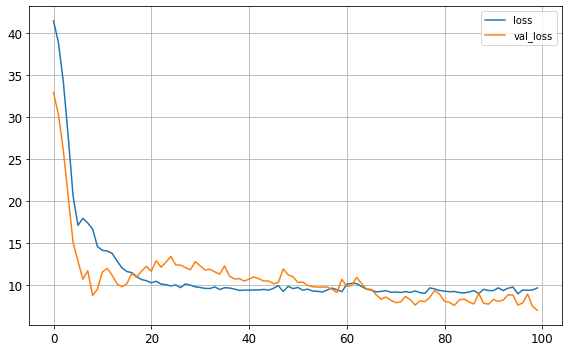

In [20]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
save_fig("grid_num_training_curve")
plt.show()

X.shape = (None, 1)
gauss_grid.shape = (None, 5)
Saving figure grid_num_prediction


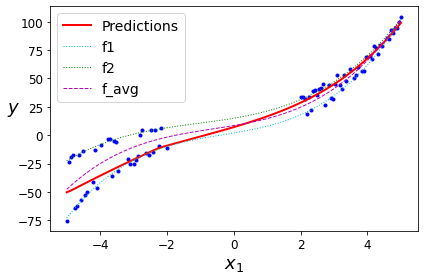

In [21]:
# X_new = np.linspace(-5, 5, 100).reshape(100, 1)
# y_new = model.predict(X_new)
#
plt.plot(X_train, y_train, "b.")
# plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
draw_func(model.predict, mark='r-', linewidth=2, label="Predictions")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
save_fig("grid_num_prediction")
plt.show()

In [22]:
get_prediction_error(model.predict, func_dict, name="grid-num")

y_func.shape = (100, 1)
y_gt.shape = (100, 1)


4.957840240394256

# Grid & Regression by Classification (grid --> grid)

In [23]:
class num2grid_np():
    def __init__(self, units, x_min=-10, x_max=10, sigma=1.0):
        self.units = units
        self.x_min = x_min
        self.x_max = x_max
        self.sigma = sigma
        self.sigma2 = self.sigma**2
        self.x_grid = np.linspace(self.x_min, self.x_max, self.units, endpoint=True)
        print("self.x_grid = %s" % str(self.x_grid))
        
    def convert(self, X):
        gauss_grid = np.exp( -(self.x_grid - X)**2 / (2.0*self.sigma2) )
#         if len(gauss_grid.shape) == 1:
#             gauss_grid = gauss_grid.reshape([1,-1])
#         grid_sum = np.sum(gauss_grid, axis=1, keepdims=True)
        grid_sum = np.sum(gauss_grid, axis=-1, keepdims=True)
        gauss_grid = gauss_grid / grid_sum
        return gauss_grid
    
    def inv_convert(self, grid):
#         if len(grid.shape) == 1:
#             grid = grid.reshape([1,-1])
#         grid_sum = np.sum(grid, axis=1)
        grid_sum = np.sum(grid, axis=-1)
#         print(grid_sum)
        exp_num = np.sum((self.x_grid * grid), axis=-1) / grid_sum # element-wise
        return exp_num
    
    def get_statistic(self, grid):
        grid_sum = np.sum(grid, axis=-1)
        _mean = np.sum((self.x_grid * grid), axis=-1) / grid_sum # element-wise
        _var  = np.sum( ((self.x_grid.reshape((1,-1)) - _mean.reshape((-1,1)))**2 * grid), axis=-1) / grid_sum # element-wise
        # print("(_mean, _var) = (%f, %f)" % (_mean, _var))
        _stddev = np.sqrt(_var)
        return _mean, _stddev

In [24]:
# class_num = 10 # 10
# n2g = num2grid_np(class_num, x_min=-100.0, x_max=100.0, sigma=20.0) # 20.0
# class_num = 20
# n2g = num2grid_np(class_num, x_min=-100.0, x_max=100.0, sigma=15.0) # 20.0
class_num = 50
n2g = num2grid_np(class_num, x_min=-100.0, x_max=100.0, sigma=6.0) # 5.0 

self.x_grid = [-100.          -95.91836735  -91.83673469  -87.75510204  -83.67346939
  -79.59183673  -75.51020408  -71.42857143  -67.34693878  -63.26530612
  -59.18367347  -55.10204082  -51.02040816  -46.93877551  -42.85714286
  -38.7755102   -34.69387755  -30.6122449   -26.53061224  -22.44897959
  -18.36734694  -14.28571429  -10.20408163   -6.12244898   -2.04081633
    2.04081633    6.12244898   10.20408163   14.28571429   18.36734694
   22.44897959   26.53061224   30.6122449    34.69387755   38.7755102
   42.85714286   46.93877551   51.02040816   55.10204082   59.18367347
   63.26530612   67.34693878   71.42857143   75.51020408   79.59183673
   83.67346939   87.75510204   91.83673469   95.91836735  100.        ]


In [25]:
# grid_1 = n2g.convert(-1.2)
grid_1 = n2g.convert([[-1.2]])
print(grid_1)

[[3.57995092e-60 2.08100846e-55 7.61538914e-51 1.75441300e-46
  2.54444491e-42 2.32314196e-38 1.33530332e-34 4.83176258e-31
  1.10065884e-27 1.57841554e-24 1.42498879e-21 8.09884396e-19
  2.89771784e-16 6.52695532e-14 9.25521826e-12 8.26198061e-10
  4.64304784e-08 1.64264466e-06 3.65852120e-05 5.12966502e-04
  4.52786966e-03 2.51605603e-02 8.80173281e-02 1.93837381e-01
  2.68737559e-01 2.34552834e-01 1.28876722e-01 4.45789421e-02
  9.70748025e-03 1.33077537e-03 1.14848275e-04 6.23972825e-06
  2.13416679e-07 4.59528573e-09 6.22899760e-11 5.31551427e-13
  2.85557712e-15 9.65748361e-18 2.05615356e-20 2.75593262e-23
  2.32542921e-26 1.23526215e-29 4.13082337e-33 8.69632169e-37
  1.15254011e-40 9.61607812e-45 5.05081425e-49 1.67011468e-53
  3.47658354e-58 4.55596654e-63]]


In [26]:
n2g.inv_convert(grid_1)

array([-1.2])

In [27]:
n2g.get_statistic(grid_1)

(array([-1.2]), array([6.]))

### Convert the labels to grid (pre-processing)

In [28]:
y_train_grid = n2g.convert(y_train)
y_valid_grid = n2g.convert(y_valid)

In [29]:
print(y_train_grid.shape)
print(y_valid_grid.shape)

(80, 50)
(20, 50)


In [30]:
model = keras.models.Sequential([
#     keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    num2grid(5,x_min=-10, x_max=10, sigma=3.0, input_shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
#     keras.layers.Dense(100, activation="relu", kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    keras.layers.Dense(class_num, activation="softmax"),
])

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


C:\Users\benso\anaconda3\envs\ml\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [31]:
history = model.fit(X_train, y_train_grid, epochs=100,
                    validation_data=(X_valid, y_valid_grid))

Epoch 1/100
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
1/3 [=========>....................] - ETA: 0s - loss: 3.9280X.shape = (None, 1)
gauss_grid.shape = (None, 5)
3/3 [==============================] - 1s 78ms/step - loss: 3.9215 - val_loss: 3.9173
Epoch 2/100
3/3 [==============================] - 0s 19ms/step - loss: 3.8859 - val_loss: 3.8825
Epoch 3/100
3/3 [==============================] - 0s 29ms/step - loss: 3.8293 - val_loss: 3.8490
Epoch 4/100
3/3 [==============================] - 0s 31ms/step - loss: 3.7646 - val_loss: 3.8029
Epoch 5/100
3/3 [==============================] - 0s 49ms/step - loss: 3.6912 - val_loss: 3.7463
Epoch 6/100
3/3 [==============================] - 0s 33ms/step - loss: 3.5907 - val_loss: 3.6789
Epoch 7/100
3/3 [==============================] - 0s 27ms/step - loss: 3.4747 - val_loss: 3.5994
Epoch 8/100
3/3 [==============================] - 0s 37ms/step - loss: 3.3620 - val_loss: 3.5201
Epoch 9/

3/3 [==============================] - 0s 18ms/step - loss: 2.4646 - val_loss: 2.6848
Epoch 82/100
3/3 [==============================] - 0s 22ms/step - loss: 2.4221 - val_loss: 2.5186
Epoch 83/100
3/3 [==============================] - 0s 17ms/step - loss: 2.4446 - val_loss: 2.5300
Epoch 84/100
3/3 [==============================] - 0s 22ms/step - loss: 2.4354 - val_loss: 2.6378
Epoch 85/100
3/3 [==============================] - 0s 14ms/step - loss: 2.4324 - val_loss: 2.6159
Epoch 86/100
3/3 [==============================] - 0s 22ms/step - loss: 2.4190 - val_loss: 2.5729
Epoch 87/100
3/3 [==============================] - 0s 13ms/step - loss: 2.4174 - val_loss: 2.5973
Epoch 88/100
3/3 [==============================] - 0s 20ms/step - loss: 2.4235 - val_loss: 2.6963
Epoch 89/100
3/3 [==============================] - 0s 17ms/step - loss: 2.4143 - val_loss: 2.6112
Epoch 90/100
3/3 [==============================] - 0s 21ms/step - loss: 2.4344 - val_loss: 2.6584
Epoch 91/100
3/3 [=====

Saving figure grid_rbc_training_curve


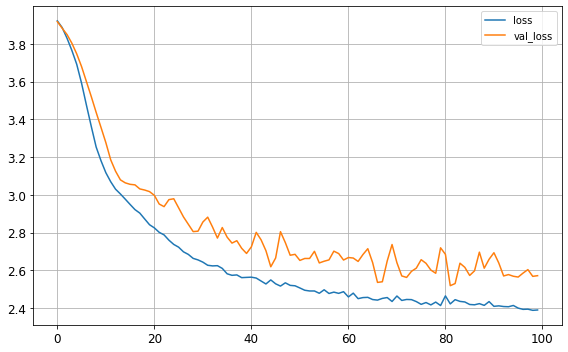

In [32]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
save_fig("grid_rbc_training_curve")
plt.show()

X.shape = (None, 1)
gauss_grid.shape = (None, 5)
Saving figure grid_rbc_prediction


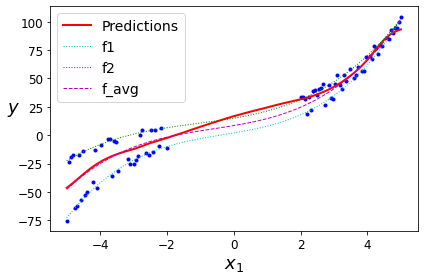

In [33]:
# X_new = np.linspace(-5, 5, 100).reshape(100, 1)
# y_new_proba = model.predict(X_new)
# y_new = n2g.inv_convert(y_new_proba)
#
plt.plot(X_train, y_train, "b.")
# plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
draw_func((lambda X: n2g.inv_convert(model.predict(X)) ), mark='r-', linewidth=2, label="Predictions")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
save_fig("grid_rbc_prediction")
plt.show()

In [34]:
get_prediction_error((lambda X: n2g.inv_convert(model.predict(X)) ), func_dict, name="grid-rbc")

y_func.shape = (100, 1)
y_gt.shape = (100, 1)


3.624877370909611

Saving figure grid_rbc_proba


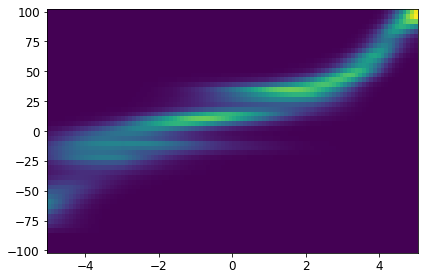

In [35]:
X_new = np.linspace(-5, 5, 100).reshape(100, 1)
y_new_proba = model.predict(X_new)
# y_new = n2g.inv_convert(y_new_proba)
#
xv, yv = np.meshgrid(X_new, np.linspace(n2g.x_min, n2g.x_max, n2g.units))
# print(xv)
# print(yv)
plt.pcolormesh(xv, yv, y_new_proba.T, shading="nearest")
save_fig("grid_rbc_proba")

### Draw the 1-sigma boundary line

Saving figure grid_rbc_prediction_1sigma


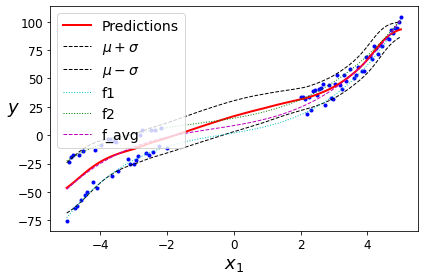

In [36]:
def n_sigma_boundary_line(X, n):
    _mean, _sigma = n2g.get_statistic(model.predict(X))
    return( _mean + n*_sigma)

plt.plot(X_train, y_train, "b.")
#
draw_func((lambda X: n2g.inv_convert(model.predict(X)) ), mark='r-', linewidth=2, label="Predictions")
draw_func((lambda X: n_sigma_boundary_line(X, +1.0) ), mark='k--', linewidth=1, label="$\mu+\sigma$")
draw_func((lambda X: n_sigma_boundary_line(X, -1.0) ), mark='k--', linewidth=1, label="$\mu-\sigma$")
#
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
save_fig("grid_rbc_prediction_1sigma")
plt.show()

# Grid & Regression by Classification + Offset Estimation (grid --> grid,num)

In [37]:
class num2gridOffset_np():
    def __init__(self, units, x_min=-10, x_max=10):
        self.units = units
        self.x_min = x_min
        self.x_max = x_max
        self.x_grid = np.linspace(self.x_min, self.x_max, self.units, endpoint=True)
        # bins
        x_space = np.average(self.x_grid[1:] - self.x_grid[:-1])
        print("x_space = %f" % x_space)
        x_0 = self.x_grid[0] - 0.5 * x_space
        self.x_bins = [x_0 + _i*x_space for _i in range(len(self.x_grid)+1)]
        print("self.x_grid = %s" % str(self.x_grid))
#         print("self.x_bins = %s" % str(self.x_bins))
        
    def convert(self, X):
        '''
        Convert a batch of number to one-hot class and numerical offset to each grid's center
        (m, 1) --> (m, n_units, 2)
        '''
        X = np.array(X)
        if len(X.shape) <= 1:
            X = X.reshape((-1,1))
        idxs_bin = np.digitize(X, self.x_bins, right=False) 
        idxs_grid = (idxs_bin - 1) + 1*(idxs_bin<= 0) - 1*(idxs_bin>=self.units)
        print(idxs_grid.shape)
        #
        batch_size = X.shape[0]
        grid = np.zeros((batch_size, self.units, 2))
        # Fill in the values
        grid[np.arange(batch_size), idxs_grid.reshape((-1,)), 0] = 1.0
        grid[np.arange(batch_size), :, 1] = X - self.x_grid.reshape((1,-1)) # Offset
        return grid
    
    def inv_convert(self, grid):
        idxs_grid = np.argmax(grid[...,0], axis=1)
        print(idxs_grid.shape)
        #
        batch_size = grid.shape[0]
        offset_est = grid[np.arange(batch_size),idxs_grid,1]
        print(offset_est.shape)
        num_est = self.x_grid[idxs_grid].reshape((1,-1)) + offset_est
        return num_est.reshape((-1,))

In [38]:
class_num = 10 # 10
n2go = num2gridOffset_np(class_num, x_min=-100.0, x_max=100.0) 

x_space = 22.222222
self.x_grid = [-100.          -77.77777778  -55.55555556  -33.33333333  -11.11111111
   11.11111111   33.33333333   55.55555556   77.77777778  100.        ]


In [39]:
# grid_1 = n2g.convert(-1.2)
grid_1 = n2go.convert([[-1.2], [50.5]])
print(grid_1)

(2, 1)
[[[   0.           98.8       ]
  [   0.           76.57777778]
  [   0.           54.35555556]
  [   0.           32.13333333]
  [   1.            9.91111111]
  [   0.          -12.31111111]
  [   0.          -34.53333333]
  [   0.          -56.75555556]
  [   0.          -78.97777778]
  [   0.         -101.2       ]]

 [[   0.          150.5       ]
  [   0.          128.27777778]
  [   0.          106.05555556]
  [   0.           83.83333333]
  [   0.           61.61111111]
  [   0.           39.38888889]
  [   0.           17.16666667]
  [   1.           -5.05555556]
  [   0.          -27.27777778]
  [   0.          -49.5       ]]]


In [40]:
n2go.inv_convert(grid_1)

(2,)
(2,)


array([-1.2, 50.5])

### Convert the labels to grid (pre-processing)

In [41]:
y_train_grid_offset = n2go.convert(y_train)
y_valid_grid_offset = n2go.convert(y_valid)

(80, 1)
(20, 1)


In [42]:
print(y_train_grid_offset.shape)
print(y_valid_grid_offset.shape)

(80, 10, 2)
(20, 10, 2)


In [43]:
inputs = keras.layers.Input(shape=X_train.shape[1:])
#
z = num2grid(5,x_min=-10, x_max=10, sigma=3.0)(inputs)
z = keras.layers.Dense(30, activation="selu")(z)
# Outputs
z_proba = keras.layers.Dense(30, activation="relu")(z)
z_proba  = keras.layers.Dense(class_num, activation="softmax")(z_proba)
z_offset = keras.layers.Dense(class_num, activation="relu")(z)
z_offset = keras.layers.Dense(class_num)(z_offset)
# Concatenate
z_proba  = keras.layers.Reshape([class_num,1])(z_proba)
z_offset = keras.layers.Reshape([class_num,1])(z_offset)
out_cat = keras.layers.Concatenate(axis=-1)([z_proba, z_offset])
#
# Models for trainig and real usage
model = keras.Model(inputs=[inputs], outputs=[out_cat])

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


In [44]:
# Customized loss function

cce = keras.losses.CategoricalCrossentropy(reduction=keras.losses.Reduction.NONE)
# cce(y_true, y_pred).numpy()

def centerLoss_fn(y_true, y_pred):
    #
    y_true_proba = y_true[...,0]
    y_true_value = y_true[...,1]
    #
    y_pred_proba = y_pred[...,0]
    y_pred_value = y_pred[...,1]
    
    #
    cce_loss = cce(y_true_proba, y_pred_proba) / class_num
    #
    y_true_value_est = tf.reduce_sum((y_true_proba * y_true_value), axis=-1)
    y_pred_value_est = tf.reduce_sum((y_true_proba * y_pred_value), axis=-1)
#     y_pred_value_est = tf.reduce_sum((y_pred_proba * y_pred_value), axis=-1)
    value_loss = tf.abs(y_pred_value_est - y_true_value_est)
    
    # Total loss
#     return (0.5*cce_loss + 0.5*value_loss )
    return (0.2*cce_loss + 0.8*value_loss )
#     return (cce_loss)
#     return (value_loss )

In [45]:
# optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9)
optimizer = keras.optimizers.Adam(lr=0.05)
model.compile(loss=centerLoss_fn, optimizer=optimizer)

C:\Users\benso\anaconda3\envs\ml\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [46]:
# history = model.fit(X_train, y_train_grid_offset, epochs=100,
#                     validation_data=(X_valid, y_valid_grid_offset))

In [47]:
# import pandas as pd

# pd.DataFrame(history.history).plot(figsize=(8, 5))
# plt.grid(True)
# # plt.gca().set_ylim(0, 1)
# save_fig("grid_rbcOffset_training_curve")
# plt.show()

In [48]:
# plt.plot(X_train, y_train, "b.")
# draw_func((lambda X: n2go.inv_convert(model.predict(X)) ), mark='r-', linewidth=2, label="Predictions")
# draw_normal_func(func_dict)
# plt.xlabel("$x_1$", fontsize=18)
# plt.ylabel("$y$", rotation=0, fontsize=18)
# plt.legend(loc="upper left", fontsize=14)
# # plt.axis([-3, 3, 0, 10])
# save_fig("grid_rbcOffset_prediction")
# plt.show()

In [49]:
# get_prediction_error((lambda X: n2go.inv_convert(model.predict(X)) ), func_dict, name="grid-classOffset")

# Parametric Uncertainty/Distribution Estimation

In this section, we try to estimate uncertainty (actually, fit the dataset distribution) with parametric reprecentation of a distribution instead of a discretized non-parametric representation.

Possible solution includes
- Quantile estimation with pinball loss (statistic)
- Guassian distribution (fit a prabability distribution)

## Quantile Estimation with Pinball Loss (grid --> parameters)

Quantile estimation and pinball loss is based on the concept of statistic, which predict the value based on the rank of samples in the dataset.

The outputs of the model are $(y_{10}, y_{90})$, 10% quantile prediction and 90% quantile prediction, respectively.

In [50]:
# quantile_list = [0.5]
# quantile_list = [0.9]
quantile_list = [0.1, 0.9] # Use hidden layer with 30 neurons
# quantile_list = [0.05, 0.95]
# quantile_list = [0.25, 0.75]
# quantile_list = [0.1, 0.5, 0.9]
# quantile_list = [0.1, 0.3, 0.7, 0.9]
# quantile_list = [0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9] # remove 0.5
# quantile_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] # Should use wider hidden layer (with many neurons) + L1 regularization
num_quantile = len(quantile_list)

In [51]:
model = keras.models.Sequential([
    num2grid(5,x_min=-10, x_max=10, sigma=3.0, input_shape=X_train.shape[1:]),
#     num2grid(50,x_min=-10, x_max=10, sigma=0.5, input_shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
#     keras.layers.Dense(60, activation="relu"),
#     keras.layers.Dense(100, activation="relu", kernel_regularizer=tf.keras.regularizers.l1(0.01)),
#     keras.layers.Dense(30, activation=keras.layers.LeakyReLU(alpha=0.2) ),
#     keras.layers.Dense(30, activation="selu"),
    keras.layers.Dense(num_quantile) # (y10, y90)
])

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


In [52]:
# Customized loss function
def pinballLoss_fn(y_true, y_pred, tau):
    # tau: quantile, tau in [0.0, 1.0]
    # y_true: label mean
    # y_pred: predicted tau quantile
    _q = y_true - y_pred
    return tf.math.maximum( (tau*_q), ((tau-1.0)*_q))
    
def pinballLoss_10_90_fn(y_true, y_pred):
    #
    return pinballLoss_fn(y_true, y_pred[:,0:1], 0.1) + pinballLoss_fn(y_true, y_pred[:,1:2], 0.9)

def pinballLoss_full_fn(y_true, y_pred):
    #
    pinball_losses = tf.stack( [pinballLoss_fn(y_true, y_pred[:, _i:(_i+1)], _tau) for _i, _tau in enumerate(quantile_list)], axis=1)
    return tf.reduce_sum(pinball_losses, axis=1)

In [53]:
# optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9)
optimizer = keras.optimizers.Adam(lr=0.1)
# model.compile(loss=pinballLoss_10_90_fn, optimizer=optimizer)
model.compile(loss=pinballLoss_full_fn, optimizer=optimizer)

In [54]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid))

Epoch 1/100
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
1/3 [=========>....................] - ETA: 0s - loss: 42.3910X.shape = (None, 1)
gauss_grid.shape = (None, 5)
3/3 [==============================] - 1s 95ms/step - loss: 41.0556 - val_loss: 31.2403
Epoch 2/100
3/3 [==============================] - 0s 17ms/step - loss: 36.7093 - val_loss: 25.7834
Epoch 3/100
3/3 [==============================] - 0s 36ms/step - loss: 29.6143 - val_loss: 18.5435
Epoch 4/100
3/3 [==============================] - 0s 27ms/step - loss: 22.1241 - val_loss: 12.6381
Epoch 5/100
3/3 [==============================] - 0s 33ms/step - loss: 16.5137 - val_loss: 12.3717
Epoch 6/100
3/3 [==============================] - 0s 34ms/step - loss: 13.7279 - val_loss: 13.7016
Epoch 7/100
3/3 [==============================] - 0s 20ms/step - loss: 14.2204 - val_loss: 13.9120
Epoch 8/100
3/3 [==============================] - 0s 36ms/step - loss: 14.2038 - val_loss:

3/3 [==============================] - 0s 18ms/step - loss: 2.8710 - val_loss: 2.7323
Epoch 82/100
3/3 [==============================] - 0s 22ms/step - loss: 2.6022 - val_loss: 2.6291
Epoch 83/100
3/3 [==============================] - 0s 19ms/step - loss: 2.5935 - val_loss: 2.6852
Epoch 84/100
3/3 [==============================] - 0s 22ms/step - loss: 2.6017 - val_loss: 2.8583
Epoch 85/100
3/3 [==============================] - 0s 14ms/step - loss: 2.6583 - val_loss: 2.6792
Epoch 86/100
3/3 [==============================] - 0s 22ms/step - loss: 2.5874 - val_loss: 2.7323
Epoch 87/100
3/3 [==============================] - 0s 17ms/step - loss: 2.9805 - val_loss: 3.1729
Epoch 88/100
3/3 [==============================] - 0s 18ms/step - loss: 3.2016 - val_loss: 3.5308
Epoch 89/100
3/3 [==============================] - 0s 19ms/step - loss: 3.3555 - val_loss: 3.5808
Epoch 90/100
3/3 [==============================] - 0s 14ms/step - loss: 3.2116 - val_loss: 2.9380
Epoch 91/100
3/3 [=====

Saving figure grid_quantile_training_curve


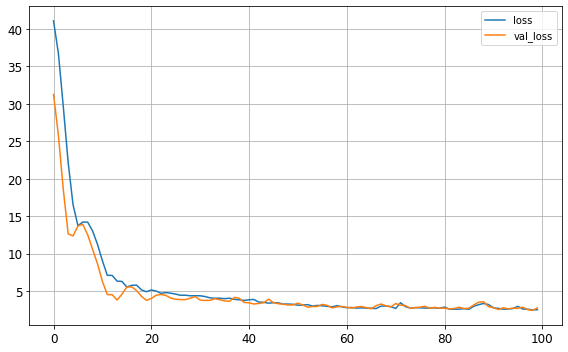

In [55]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
save_fig("grid_quantile_training_curve")
plt.show()

### Draw the mean prediction curve averaged from all quantile predictions.

X.shape = (None, 1)
gauss_grid.shape = (None, 5)
Saving figure grid_quantile_prediction


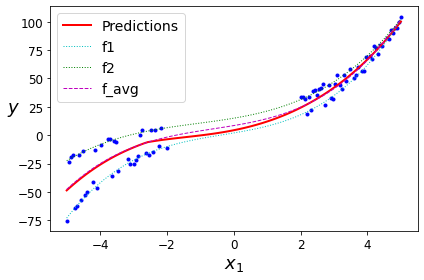

In [56]:
plt.plot(X_train, y_train, "b.")
draw_func((lambda X: np.average(model.predict(X), axis=-1) ), mark='r-', linewidth=2, label="Predictions")
# draw_func((lambda X: model.predict(X)[:,0] ), mark='k--', linewidth=1, label="$y_{%d}$" % (quantile_list[0]*100))
# draw_func((lambda X: model.predict(X)[:,-1] ), mark='k--', linewidth=1, label="$y_{%d}$" % (quantile_list[-1]*100))
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
save_fig("grid_quantile_prediction")
plt.show()

In [57]:
get_prediction_error((lambda X: np.average(model.predict(X), axis=-1) ), func_dict, name="grid-quantileR")

y_func.shape = (100, 1)
y_gt.shape = (100, 1)


1.662495768911993

### Draw first and last quantile curve.

Saving figure grid_quantile_boundary_quantiles


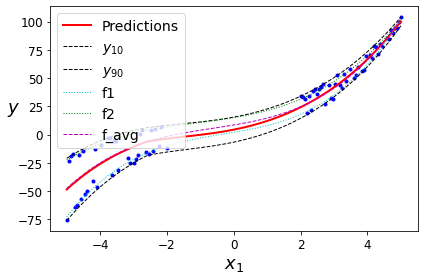

In [58]:
plt.plot(X_train, y_train, "b.")
draw_func((lambda X: np.average(model.predict(X), axis=-1) ), mark='r-', linewidth=2, label="Predictions")
draw_func((lambda X: model.predict(X)[:,0] ), mark='k--', linewidth=1, label="$y_{%d}$" % (quantile_list[0]*100))
draw_func((lambda X: model.predict(X)[:,-1] ), mark='k--', linewidth=1, label="$y_{%d}$" % (quantile_list[-1]*100))
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
save_fig("grid_quantile_boundary_quantiles")
plt.show()

### Draw all quantile predictions

Saving figure grid_quantile_all_quantiles


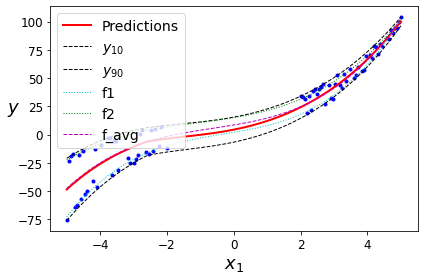

In [59]:
plt.plot(X_train, y_train, "b.")
draw_func((lambda X: np.average(model.predict(X), axis=-1) ), mark='r-', linewidth=2, label="Predictions")
for _idx, _tau in enumerate(quantile_list):
    draw_func((lambda X: model.predict(X)[:,_idx] ), mark='k--', linewidth=1, label="$y_{%d}$" % (_tau*100))
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
save_fig("grid_quantile_all_quantiles")
plt.show()

### Multi-Quantiles as a Gaussian Distribution 

In [60]:
# def n_sigma_boundary_line(X, n):
#     _y = model.predict(X)
#     _mean = np.mean(_y, axis=-1)
#     _sigma = np.std(_y, axis=-1)
#     return( _mean + n*_sigma)

# plt.plot(X_train, y_train, "b.")
# #
# draw_func((lambda X: np.average(model.predict(X), axis=-1) ), mark='r-', linewidth=2, label="Predictions")
# draw_func((lambda X: n_sigma_boundary_line(X, +1.0) ), mark='k--', linewidth=1, label="$\mu+\sigma$")
# draw_func((lambda X: n_sigma_boundary_line(X, -1.0) ), mark='k--', linewidth=1, label="$\mu-\sigma$")
# #
# draw_normal_func(func_dict)
# plt.xlabel("$x_1$", fontsize=18)
# plt.ylabel("$y$", rotation=0, fontsize=18)
# plt.legend(loc="upper left", fontsize=14)
# # plt.axis([-3, 3, 0, 10])
# save_fig("grid_quantile_1sigma")
# plt.show()

## Gaussian Estimation with Gaussian Loss (grid-->parameters)

Gaussain estimation requires the model to predict the mean and variance of a Gaussian distribution of the random variable regarded. The training purpose is to fit a Gaussian distribution to the data distribution (which is not necessay distributed as Gaussian).

One possible solution, derived by BensonHuang, is that the model estimates $(\mu, z)$, where $z=\alpha ^{-1}log(\sigma)$.
The associated loss function can be $L_G(y, (\mu,z)) = 0.5e^{-2\alpha z}(y-\mu)^2 + \alpha z$.

In [61]:
alpha = 1.0
# alpha = 0.01
# alpha = 0.001

In [62]:
model = keras.models.Sequential([
    num2grid(5,x_min=-10, x_max=10, sigma=3.0, input_shape=X_train.shape[1:]),
#     keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(60, activation="relu"),
#     keras.layers.Dense(30, activation=keras.layers.LeakyReLU(alpha=0.2) ),
#     keras.layers.Dense(30, activation="selu"),
    keras.layers.Dense(2) # (mu, z)
])

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


In [63]:
# Customized loss function
print("alpha = %f" % alpha)

def GaussianLoss_fn(y_true, y_pred):
    # y_true: label 
    # y_pred: (mu, z), z=log(sigma)
    mu = y_pred[:, 0:1]
    z  = y_pred[:, 1:2]
    #
    en2z = tf.math.exp((-2.0*alpha)*z)
    ymu2 = (y_true - mu)**2
    return (0.5*en2z*ymu2 + alpha*z)

alpha = 1.000000


In [64]:
# Learning rate scheduler
learning_rate_switch_epoch_list = [30, 45]
learning_rate_list = [0.001, 0.01, 0.1]
# learning_rate_switch_epoch_list = [30, 80]
# learning_rate_list = [0.01, 0.1, 0.01]
#
def piecewise_constant_fn(epoch):
    for _i, epoch_s in enumerate(learning_rate_switch_epoch_list):
        if epoch < epoch_s:
            return learning_rate_list[_i]
    return learning_rate_list[-1]

lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

Third training with even greater speed

In [65]:
# optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9)
optimizer = keras.optimizers.Adam(lr=0.1)
model.compile(loss=GaussianLoss_fn, optimizer=optimizer)

C:\Users\benso\anaconda3\envs\ml\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [66]:
history = model.fit(X_train, y_train, epochs=200,
                    validation_data=(X_valid, y_valid))

Epoch 1/200
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
1/3 [=========>....................] - ETA: 0s - loss: 1303.0731X.shape = (None, 1)
gauss_grid.shape = (None, 5)
3/3 [==============================] - 1s 84ms/step - loss: 532.2187 - val_loss: 6.2785
Epoch 2/200
3/3 [==============================] - 0s 15ms/step - loss: 7.8004 - val_loss: 11.7693
Epoch 3/200
3/3 [==============================] - 0s 32ms/step - loss: 12.9885 - val_loss: 15.9217
Epoch 4/200
3/3 [==============================] - 0s 42ms/step - loss: 16.8454 - val_loss: 18.7982
Epoch 5/200
3/3 [==============================] - 0s 41ms/step - loss: 19.4986 - val_loss: 20.5803
Epoch 6/200
3/3 [==============================] - 0s 23ms/step - loss: 21.1227 - val_loss: 21.4838
Epoch 7/200
3/3 [==============================] - 0s 27ms/step - loss: 21.9352 - val_loss: 21.7525
Epoch 8/200
3/3 [==============================] - 0s 36ms/step - loss: 22.1535 - val_loss

3/3 [==============================] - 0s 19ms/step - loss: 3.3171 - val_loss: 3.3775
Epoch 82/200
3/3 [==============================] - 0s 21ms/step - loss: 3.3640 - val_loss: 3.3299
Epoch 83/200
3/3 [==============================] - 0s 21ms/step - loss: 3.2953 - val_loss: 3.3354
Epoch 84/200
3/3 [==============================] - 0s 21ms/step - loss: 3.2790 - val_loss: 3.2822
Epoch 85/200
3/3 [==============================] - 0s 21ms/step - loss: 3.2736 - val_loss: 3.2527
Epoch 86/200
3/3 [==============================] - 0s 18ms/step - loss: 3.2579 - val_loss: 3.2599
Epoch 87/200
3/3 [==============================] - 0s 17ms/step - loss: 3.2814 - val_loss: 3.2667
Epoch 88/200
3/3 [==============================] - 0s 22ms/step - loss: 3.2561 - val_loss: 3.2825
Epoch 89/200
3/3 [==============================] - 0s 14ms/step - loss: 3.2458 - val_loss: 3.3002
Epoch 90/200
3/3 [==============================] - 0s 21ms/step - loss: 3.2417 - val_loss: 3.2757
Epoch 91/200
3/3 [=====

3/3 [==============================] - 0s 22ms/step - loss: 3.4768 - val_loss: 3.2977
Epoch 164/200
3/3 [==============================] - 0s 21ms/step - loss: 3.3159 - val_loss: 3.3105
Epoch 165/200
3/3 [==============================] - 0s 23ms/step - loss: 3.2506 - val_loss: 3.2006
Epoch 166/200
3/3 [==============================] - 0s 17ms/step - loss: 2.9164 - val_loss: 3.1750
Epoch 167/200
3/3 [==============================] - 0s 17ms/step - loss: 2.9624 - val_loss: 3.0419
Epoch 168/200
3/3 [==============================] - 0s 18ms/step - loss: 2.9989 - val_loss: 3.0560
Epoch 169/200
3/3 [==============================] - 0s 22ms/step - loss: 2.9367 - val_loss: 2.8643
Epoch 170/200
3/3 [==============================] - 0s 22ms/step - loss: 2.8063 - val_loss: 2.9368
Epoch 171/200
3/3 [==============================] - 0s 18ms/step - loss: 2.8009 - val_loss: 2.9723
Epoch 172/200
3/3 [==============================] - 0s 17ms/step - loss: 2.8129 - val_loss: 2.9174
Epoch 173/200


In [67]:
# history = model.fit(X_train, y_train, epochs=145,
#                     validation_data=(X_valid, y_valid), callbacks=[lr_scheduler])

Saving figure grid_Gaussian_training_curve


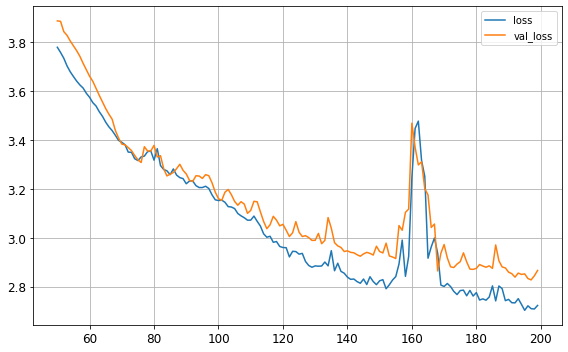

In [68]:
import pandas as pd

# print(history.history)
try:
    lr_list = history.history["lr"]
    del(history.history["lr"])
except:
    pass

pd.DataFrame(history.history)[50:].plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
save_fig("grid_Gaussian_training_curve")
plt.show()

X.shape = (None, 1)
gauss_grid.shape = (None, 5)
Saving figure grid_Gaussian_prediction


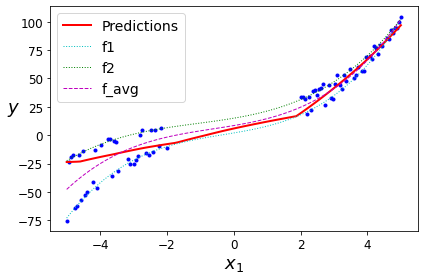

In [69]:
plt.plot(X_train, y_train, "b.")
draw_func((lambda X: model.predict(X)[:,0] ), mark='r-', linewidth=2, label="Predictions")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
save_fig("grid_Gaussian_prediction")
plt.show()

In [70]:
get_prediction_error((lambda X: model.predict(X)[:,0] ), func_dict, name="grid-oneGaussian")

y_func.shape = (100, 1)
y_gt.shape = (100, 1)


4.2881265131305195

### Draw the 1-sigma boundary line

Saving figure grid_Gaussian_1sigma


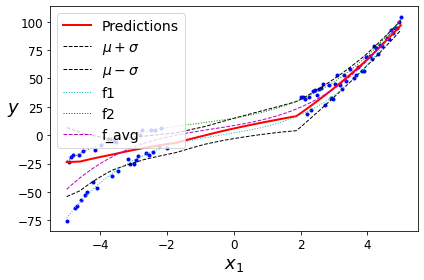

In [71]:
def n_sigma_boundary_line(X, n):
    _y = model.predict(X)
    _mean, _z = _y[:,0:1], _y[:,1:2]
    _sigma = np.exp(alpha*_z)
    return( _mean + n*_sigma)

plt.plot(X_train, y_train, "b.")
#
draw_func((lambda X: model.predict(X)[:,0] ), mark='r-', linewidth=2, label="Predictions")
draw_func((lambda X: n_sigma_boundary_line(X, +1.0) ), mark='k--', linewidth=1, label="$\mu+\sigma$")
draw_func((lambda X: n_sigma_boundary_line(X, -1.0) ), mark='k--', linewidth=1, label="$\mu-\sigma$")
#
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
save_fig("grid_Gaussian_1sigma")
plt.show()

# Summary

In [72]:
results = print_all_prediction_error()

num-num: 5.393838
grid-num: 4.957840
grid-rbc: 3.624877
grid-quantileR: 1.662496
grid-oneGaussian: 4.288127



In [73]:
save_prediction_errors()

Saving all prediction errors to [.\images\regression_test_2\prediction_errors.txt].


True